In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# 1) Load Data
input_path = r"C:\Users\musab\Desktop\htOld\2025\code\hyperThyroid2025April11ExcelCSV.csv"
output_path_catboost = r"C:\Users\musab\Desktop\htOld\2025\code\hyperThyroid_catboost_imputed_with_eval_numeric_scaled.xlsx" # Updated output path
output_path_catboost_csv = output_path_catboost.replace('.xlsx', '.csv')

try:
    df = pd.read_csv(input_path, encoding='latin-1')
    print("Original Data Shape:", df.shape)
    print("Original Columns:", list(df.columns))
except FileNotFoundError:
    print(f"Error: Input file not found at {input_path}")
    exit() # Exit if the file doesn't exist
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

# 2) Targets & features map (Unchanged)
imputation_map = {
    'urinary_calcium_24h': [
        'aphp','pth_div_phosphorus','secondary_hp',
        'corrected_calcium_by_albumin_div_phosphorus',
        'serum_creatinine','serum_calcium','pth','corrected_calcium_by_albumin'
    ],
    'chlorine': [
        'gfr','serum_creatinine','bun','urinary_calcium_24h',
        'serum_calcium','phosphorus','pth','corrected_calcium_by_albumin',
        'serum_calcium_phosphorus_ratio','ast','pf_index',
        'alp_value','polyuria','polydipsia'
    ],
    'gfr': [
        'aphp','secondary_hp','pth_div_phosphorus',
        'corrected_calcium_by_albumin_div_phosphorus',
        'nephrolithiasis','myalgia','serum_creatinine',
        'serum_calcium','corrected_calcium_by_albumin','pth',
        'bun','serum_25_hydroxy_vitamin_d','alt','ast'
    ],
    'serum_calcium_phosphorus_ratio': [
        'aphp','alp_value','pth_div_phosphorus',
        'nephrolithiasis','myalgia','secondary_hp',
        'pth','serum_calcium','corrected_calcium_by_albumin',
        'alt','ast'
    ],
    'phosphorus': [
        'pth_div_phosphorus','corrected_calcium_by_albumin_div_phosphorus',
        'pth','corrected_calcium_by_albumin','serum_calcium','alt','ast'
    ],
    'height': [
        'gender','bmi_value','fatigue','pth_div_phosphorus'
    ],
    'weight': [
        'bmi_value','gender','aphp','pth_div_phosphorus','fatigue'
    ],
    'pf_index': [
        'alp_combined_with_cl_po4_newValue',
        'tobacco','abdominal_pain','fatigue',
        'constipation','insomnia','gender'
    ],
    'total_cholesterol': [
        'nhph','alp_value','muscle_weakness','polyuria','amnesia',
        'polydipsia','fracture_present','headache','gallstones',
        'nausea','gender','fatigue','myalgia','constipation',
        'insomnia','pth_div_phosphorus','corrected_calcium_by_albumin_div_phosphorus'
    ],
    'bun': [
        'aphp','polyuria','amnesia','muscle_weakness','polydipsia',
        'gallstones','fracture_present','fatigue','nausea',
        'headache','kidney_stones_present','gender','myalgia',
        'secondary_hp','insomnia','pth_div_phosphorus',
        'corrected_calcium_by_albumin_div_phosphorus'
    ],
    'ldl_cholesterol': [
        'aphp','kidney_stones_present','fatigue','polydipsia',
        'polyuria','amnesia','nausea','muscle_weakness',
        'fracture_present','constipation','headache',
        'gallstones','nephrolithiasis','nhph','myalgia','secondary_hp'
    ],
    'ggt': [
        'alp_value','alp_combined_with_cl_po4_newValue','tobacco',
        'aphp','constipation','kidney_stones_present',
        'pth_div_phosphorus','insomnia','nephrolithiasis',
        'fatigue','corrected_calcium_by_albumin_div_phosphorus',
        'muscle_weakness','polyuria','polydipsia','amnesia',
        'fracture_present'
    ],
    # 13. Triglycerides
    'Triglycerides': [
        'nhph','muscle_weakness','amnesia','polyuria','fracture_present','gender',
        'total_cholesterol','serum_calcium_phosphorus_ratio','urinary_calcium_24h',
        'serum_25_hydroxy_vitamin_d','pth','serum_calcium','gfr'
    ],
    # 14. Magnesium
    'magnesium': [
        'aphp','secondary_hp','kidney_stones_present','fatigue','fracture_present',
        'gfr','serum_calcium_phosphorus_ratio','urinary_calcium_24h',
        'ldl_cholesterol','serum_calcium','serum_25_hydroxy_vitamin_d',
        'corrected_calcium_by_albumin'
    ],
    # 15. Serum 25-hydroxy vitamin D
    'serum_25_hydroxy_vitamin_d': [
        'fracture_present','amnesia','muscle_weakness','polyuria','polydipsia',
        'headache','gallstones','nhph',
        'gfr','serum_calcium_phosphorus_ratio','urinary_calcium_24h',
        'total_cholesterol','Triglycerides','serum_calcium','alt','corrected_calcium_by_albumin'
    ],
    # 16. Albumin
    'albumin': [
        'secondary_hp','nhph','fatigue','kidney_stones_present','alp_value',
        'constipation','aphp','pth_div_phosphorus','corrected_calcium_by_albumin_div_phosphorus',
        'insomnia','serum_calcium_phosphorus_ratio','total_cholesterol','ldl_cholesterol',
        'gfr','serum_creatinine','corrected_calcium_by_albumin'
    ],
    # 17. Corrected calcium by albumin
    'corrected_calcium_by_albumin': [
        'serum_calcium','albumin','gfr','urinary_calcium_24h',
        'serum_calcium_phosphorus_ratio','alt','ast','pth',
        'serum_25_hydroxy_vitamin_d','phosphorus','total_cholesterol',
        'Triglycerides','serum_creatinine','chlorine','age'
    ],
    # 18. Age
    'age': [
        'fracture_present','gallstones','muscle_weakness','amnesia',
        'polyuria','polydipsia','headache','nausea','gender'
    ],
    # 19. AST
    'ast': [
        'polyuria','polydipsia','amnesia','muscle_weakness','fracture_present',
        'gallstones','headache','nausea','gender',
        'serum_calcium','alt','pth','serum_25_hydroxy_vitamin_d'
    ],
    # 20. PTH
    'pth': [
        'amnesia','gallstones','polyuria','muscle_weakness','polydipsia',
        'fracture_present','headache','nausea','gender',
        'serum_calcium','alt','ast','serum_25_hydroxy_vitamin_d'
    ],
    # 21. ALT
    'alt': [
        'gender','bmi_value','muscle_weakness','headache','polyuria',
        'polydipsia','amnesia','serum_calcium','serum_25_hydroxy_vitamin_d',
        'pth','ast','albumin','Triglycerides'
    ],
    # 22. Serum creatinine
    'serum_creatinine': [
        'gender','bmi_value','muscle_weakness','age',
        'serum_25_hydroxy_vitamin_d','phosphorus','albumin',
        'Triglycerides','pth'
    ],
    # 23. Serum calcium
    'serum_calcium': [
        'fracture_present','gallstones','muscle_weakness','amnesia',
        'polyuria','polydipsia','gender','age','pth',
        'serum_25_hydroxy_vitamin_d','magnesium','phosphorus',
        'albumin','Triglycerides','ast','alt'
    ],
}

# --- Preprocessing ---
# Check for missing feature columns needed by the imputation map
all_imputation_features = set(f for feats in imputation_map.values() for f in feats)
missing_imputation_cols = [col for col in all_imputation_features if col not in df.columns]
if missing_imputation_cols:
    print(f"Warning: The following required feature columns are missing: {missing_imputation_cols}")
    # Remove targets that rely on missing features
    imputation_map = {
        target: feats for target, feats in imputation_map.items()
        if not any(f in missing_imputation_cols for f in feats)
    }
    print("Imputation will be skipped for targets requiring these missing features.")

# Convert specific object columns that should be treated as categorical
# Other columns (0, 1, -1 etc.) are assumed numeric.
categorical_features_names = [] # Keep track of explicitly categorical features
potential_object_cols = ['gender'] # Add any other columns that might be loaded as strings
print(f"Checking potential object columns for conversion: {potential_object_cols}")
converted_count = 0
for col in potential_object_cols:
    if col in df.columns and df[col].dtype == 'object':
        try:
            # Convert object columns to category for CatBoost explicit handling
            df[col] = df[col].fillna('NaN_placeholder') # Handle NaNs before conversion
            df[col] = df[col].astype('category')
            categorical_features_names.append(col) # Add to list of categorical features
            print(f"Converted object column '{col}' to category dtype.")
            converted_count += 1
        except Exception as e:
            print(f"Warning: Could not convert column '{col}' to category: {e}")
print(f"Converted {converted_count} object columns to category dtype.")
print(f"Identified categorical columns: {categorical_features_names}")

# --- End Preprocessing ---

# Dataframe to store evaluation results
evaluation_results = {}

# 3) Loop through each target variable for imputation
print("\n--- Starting CatBoost Imputation with Scaling ---")
for target, feats in imputation_map.items():
    if target not in df.columns:
        print(f"Skipping target '{target}' as it's not in the DataFrame.")
        continue

    # Ensure target column is numeric
    if not pd.api.types.is_numeric_dtype(df[target]):
        print(f"Attempting to convert target column '{target}' to numeric...")
        df[target] = pd.to_numeric(df[target], errors='coerce')
        if df[target].isnull().all():
             print(f"Warning: Target column '{target}' could not be converted to numeric or is all NaN. Skipping.")
             continue
        else:
             print(f"Successfully converted '{target}' to numeric.")

    imp_col = f"{target}_imputed_catboost"
    print(f"\nProcessing target: {target}...")

    # Check if feature columns exist for this target
    current_missing_feats = [f for f in feats if f not in df.columns]
    if current_missing_feats:
        print(f"Warning: Missing feature columns for '{target}': {current_missing_feats}. Skipping.")
        continue

    # a) Duplicate the original column
    df[imp_col] = df[target]

    # b) Identify indices for evaluation
    non_missing_indices = df[df[target].notna()].index
    n_eval = min(10, len(non_missing_indices)) # Use max 10 samples for evaluation
    if n_eval == 0:
        print(f"Warning: No non-missing values for '{target}' for evaluation.")
        valid_idx = pd.Index([])
        true_vals = pd.Series(dtype=float)
    else:
        # Select evaluation indices from the start for reproducibility
        valid_idx = non_missing_indices[:n_eval]
        true_vals = df.loc[valid_idx, target].copy()
        # c) Temporarily mask these values IN THE IMPUTED COLUMN
        df.loc[valid_idx, imp_col] = np.nan
        print(f"Holding out {n_eval} values for evaluation.")

    # d) Prepare data: Identify indices with missing values *in the imputed column*
    # This now includes the temporarily masked evaluation samples
    missing_idx = df[df[imp_col].isna()].index
    present_idx = df[df[imp_col].notna()].index # Indices with present values for training

    if len(present_idx) < 10: # Increased minimum threshold slightly
        print(f"Warning: Not enough data ({len(present_idx)}) to reliably train for '{target}'. Skipping.")
        if len(valid_idx) > 0: df.loc[valid_idx, imp_col] = true_vals # Restore originals
        evaluation_results[target] = {'Mean AbsErr': np.nan, 'Mean RelErr': np.nan}
        continue

    if len(missing_idx) == 0:
        print(f"No missing values (including evaluation set) to impute for '{target}'. Skipping model training.")
        # Need to restore eval values if they were masked
        if len(valid_idx) > 0: df.loc[valid_idx, imp_col] = true_vals
        evaluation_results[target] = {'Mean AbsErr': np.nan, 'Mean RelErr': np.nan} # No error if no imputation done
        continue

    print(f"Preparing data for '{target}': {len(present_idx)} training samples -> {len(missing_idx)} values to impute.")
    X = df.loc[:, feats] # Select features
    y = df.loc[:, imp_col] # Select the target column (with NaNs)

    X_train = X.loc[present_idx, :]
    y_train = y.loc[present_idx]
    X_missing = X.loc[missing_idx, :] # Features for rows where target is missing

    # Split training data for early stopping evaluation
    try:
         X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
             X_train, y_train, test_size=0.15, random_state=42 # Use 15% for validation
         )
    except ValueError as e:
         print(f"Error during train-test split for {target} (likely too few samples): {e}. Skipping.")
         if len(valid_idx) > 0: df.loc[valid_idx, imp_col] = true_vals # Restore originals
         evaluation_results[target] = {'Mean AbsErr': np.nan, 'Mean RelErr': np.nan}
         continue

    # --- Feature Imputation (Median) ---
    # Impute NaNs in FEATURES after splitting to avoid data leakage
    # Calculate median based ONLY on the training part (X_train_part)
    print("Applying median imputation for NaNs in numeric features (post-split)...")
    # Identify numeric features available in the current feature set 'feats'
    numeric_feats_in_use = X_train_part.select_dtypes(include=np.number).columns.tolist()
    # Also include binary-like features (0, 1, -1) if they are not already number
    for f in feats:
        if f not in numeric_feats_in_use and df[f].dropna().isin([0, 1, -1]).all():
             if f not in numeric_feats_in_use:
                 numeric_feats_in_use.append(f)


    imputed_feature_count = 0
    medians = {} # Store medians calculated from training data

    # Use .copy() to avoid SettingWithCopyWarning
    X_train_part = X_train_part.copy()
    X_val_part = X_val_part.copy()
    X_missing = X_missing.copy()

    for col in numeric_feats_in_use:
        if X_train_part[col].isnull().any():
            median_val = X_train_part[col].median()
            medians[col] = median_val # Store median

            # Impute training, validation, and missing sets
            X_train_part.loc[:, col] = X_train_part[col].fillna(median_val)
            X_val_part.loc[:, col] = X_val_part[col].fillna(median_val) # Use train median for validation set
            X_missing.loc[:, col] = X_missing[col].fillna(median_val)   # Use train median for missing set
            imputed_feature_count += 1

    if imputed_feature_count > 0:
        print(f"Imputed NaNs in {imputed_feature_count} numeric feature columns using training medians.")
    # Handle potential NaNs in categorical features (replace with a placeholder)
    categorical_feats_in_use = [f for f in feats if f in categorical_features_names]
    for col in categorical_feats_in_use:
        # Use .loc to ensure modification happens correctly
        if X_train_part[col].isnull().any(): X_train_part.loc[:, col] = X_train_part[col].cat.add_categories('NaN_placeholder').fillna('NaN_placeholder')
        if X_val_part[col].isnull().any(): X_val_part.loc[:, col] = X_val_part[col].cat.add_categories('NaN_placeholder').fillna('NaN_placeholder')
        if X_missing[col].isnull().any(): X_missing.loc[:, col] = X_missing[col].cat.add_categories('NaN_placeholder').fillna('NaN_placeholder')


    # --- Feature Scaling (StandardScaler) ---
    print("Applying StandardScaler to numeric features...")
    scaler = StandardScaler()
    # Identify numeric columns AGAIN after imputation (should be the same, but safer)
    numeric_cols_to_scale = X_train_part.select_dtypes(include=np.number).columns.tolist()

    if not numeric_cols_to_scale:
        print("Warning: No numeric columns found to scale for target:", target)
    else:
        # Fit scaler ONLY on the training part's numeric columns
        scaler.fit(X_train_part[numeric_cols_to_scale])

        # Transform numeric columns in training, validation, and missing sets
        # Use .loc to assign back to the correct slice and avoid warnings
        X_train_part.loc[:, numeric_cols_to_scale] = scaler.transform(X_train_part[numeric_cols_to_scale])
        X_val_part.loc[:, numeric_cols_to_scale] = scaler.transform(X_val_part[numeric_cols_to_scale])
        X_missing.loc[:, numeric_cols_to_scale] = scaler.transform(X_missing[numeric_cols_to_scale])
        print(f"Scaled {len(numeric_cols_to_scale)} numeric features.")

    # --- CatBoost Model Training ---
    # Find indices/names of categorical features within the current 'feats' list
    cat_features_indices = [i for i, f in enumerate(feats) if f in categorical_features_names]
    if cat_features_indices:
        print(f"Providing categorical feature indices to CatBoost: {cat_features_indices} (corresponding to features: {[feats[i] for i in cat_features_indices]})")


    model = CatBoostRegressor(
        iterations=150,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        loss_function='RMSE',
        eval_metric='RMSE',
        cat_features=cat_features_indices if cat_features_indices else None, # Pass categorical features if any
        verbose=0, # Suppress verbose output during training
        random_seed=42,
        early_stopping_rounds=10,
        allow_writing_files=False # Good practice
        # nan_mode='Min' # Not needed if we pre-impute NaNs in features
    )

    try:
        print(f"Training CatBoost model for {target} with scaled features...")
        # Make sure eval_set uses the scaled validation data
        model.fit(
            X_train_part, y_train_part,
            eval_set=(X_val_part, y_val_part),
            # CatBoost handles categorical features specified by cat_features parameter
        )

        # f) Predict missing values using the scaled X_missing
        print("Predicting missing values using scaled features...")
        predictions = model.predict(X_missing)

        # g) Fill missing values in the *original* DataFrame's imputed column
        df.loc[missing_idx, imp_col] = predictions
        print(f"Imputed {len(missing_idx)} values for {target}.")

        # --- Evaluation ---
        # Retrieve the imputed values for the evaluation set
        imputed_eval_values = df.loc[valid_idx, imp_col].copy()
        # Restore original values in the imputed column for the evaluation set
        df.loc[valid_idx, imp_col] = true_vals

        if len(valid_idx) > 0:
            true_vals_numeric = pd.to_numeric(true_vals, errors='coerce') # Ensure true values are numeric
            imputed_eval_values_numeric = pd.to_numeric(imputed_eval_values, errors='coerce') # Ensure predictions are numeric

            # Calculate errors only where true values are not NaN
            valid_eval_mask = true_vals_numeric.notna()
            abs_err = (imputed_eval_values_numeric[valid_eval_mask] - true_vals_numeric[valid_eval_mask]).abs()
            # Avoid division by zero or NaN for relative error
            safe_denominator = true_vals_numeric[valid_eval_mask].abs().replace(0, np.nan)
            rel_err = (abs_err / safe_denominator) * 100

            print(f"-- {target} Evaluation (CatBoost with Scaling) --")
            results_text = []
            valid_eval_idx = valid_idx[valid_eval_mask] # Indices used in error calculation
            for i in valid_eval_idx:
                t = true_vals_numeric.get(i, np.nan)
                p = imputed_eval_values_numeric.get(i, np.nan)
                ae = abs_err.get(i, np.nan)
                re = rel_err.get(i, np.nan)
                # Format results carefully, handling potential NaNs from calculations
                t_str = f"{t:.4f}" if pd.notna(t) else "NaN"
                p_str = f"{p:.4f}" if pd.notna(p) else "NaN"
                ae_str = f"{ae:.4f}" if pd.notna(ae) else "NaN"
                re_str = f"{re:.2f}%" if pd.notna(re) else "NaN"
                results_text.append(f"Row {i}: True={t_str}, Pred={p_str}, AbsErr={ae_str}, RelErr={re_str}")

            if results_text: print("\n".join(results_text))
            else: print("No valid comparison points after handling NaNs.")

            mean_abs_err = abs_err.mean() # Mean ignores NaNs by default
            mean_rel_err = rel_err.mean() # Mean ignores NaNs by default
            print(f"Mean AbsErr: {mean_abs_err:.4f}, Mean RelErr: {mean_rel_err:.2f}%")
            evaluation_results[target] = {'Mean AbsErr': mean_abs_err, 'Mean RelErr': mean_rel_err}
        else:
            print(f"-- {target}: No evaluation performed.")
            evaluation_results[target] = {'Mean AbsErr': np.nan, 'Mean RelErr': np.nan}

    except Exception as e:
        print(f"Error during CatBoost process for {target}: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback
        if len(valid_idx) > 0: df.loc[valid_idx, imp_col] = true_vals # Restore on error
        evaluation_results[target] = {'Mean AbsErr': np.nan, 'Mean RelErr': np.nan}


# 5) Save the DataFrame
# 5) Save the DataFrame
print("\nAttempting to save results...")
try:
    # --- Start: Keep your existing df_save preparation code ---
    # Ensure imputed columns are numeric before saving, coerce errors if needed
    for target in imputation_map.keys():
        imp_col = f"{target}_imputed_catboost"
        if imp_col in df.columns:
            df[imp_col] = pd.to_numeric(df[imp_col], errors='coerce')

    # Convert category columns back to object for Excel/CSV compatibility if needed
    df_save = df.copy()
    for col in categorical_features_names:
        if col in df_save.columns and pd.api.types.is_categorical_dtype(df_save[col]):
             if 'NaN_placeholder' in df_save[col].cat.categories:
                 df_save[col] = df_save[col].replace('NaN_placeholder', np.nan)
             df_save[col] = df_save[col].astype(object)
    # --- End: Keep your existing df_save preparation code ---

    # --- Start: ADDED/MODIFIED CODE ---

    # Define CSV output path (derived from Excel path)
    output_path_catboost_csv = output_path_catboost.replace('.xlsx', '.csv')

    # 1. Save to Excel (as before)
    df_save.to_excel(output_path_catboost, index=False)
    print(f"Saved DataFrame (Excel) to:\n  {output_path_catboost}")

    # 2. Save to CSV
    df_save.to_csv(output_path_catboost_csv, index=False, encoding='utf-8-sig') # Use utf-8-sig for better Excel compatibility
    print(f"Saved DataFrame (CSV) to:\n  {output_path_catboost_csv}")

    # --- End: ADDED/MODIFIED CODE ---

except Exception as e:
    # Modified error message slightly to be more general
    print(f"Error saving results: {e}")
# Optional: Print summary of evaluation results
print("\n--- CatBoost Imputation (with Scaling) Evaluation Summary ---")
eval_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
eval_df = eval_df.sort_values(by='Mean RelErr', ascending=True) # Sort by relative error

# Format output for better readability
eval_df['Mean AbsErr'] = eval_df['Mean AbsErr'].map('{:.4f}'.format)
eval_df['Mean RelErr'] = eval_df['Mean RelErr'].map('{:.2f}%'.format)

print(eval_df.to_string()) # Use to_string() for console output
print("\n--- CatBoost Imputation Process Finished ---")

Original Data Shape: (1669, 54)

--- Investigating High Error for Target: pf_index ---
All intended features found in the DataFrame.
Using available features: ['alp_combined_with_cl_po4_newValue', 'tobacco', 'abdominal_pain', 'fatigue', 'constipation', 'insomnia', 'gender']

--- pf_index Distribution Analysis ---

Basic Statistics for pf_index:
count     404.000000
mean      514.381243
std       651.354011
min        34.680000
25%       222.909091
50%       343.714782
75%       528.650000
max      7221.800000
Name: pf_index, dtype: float64


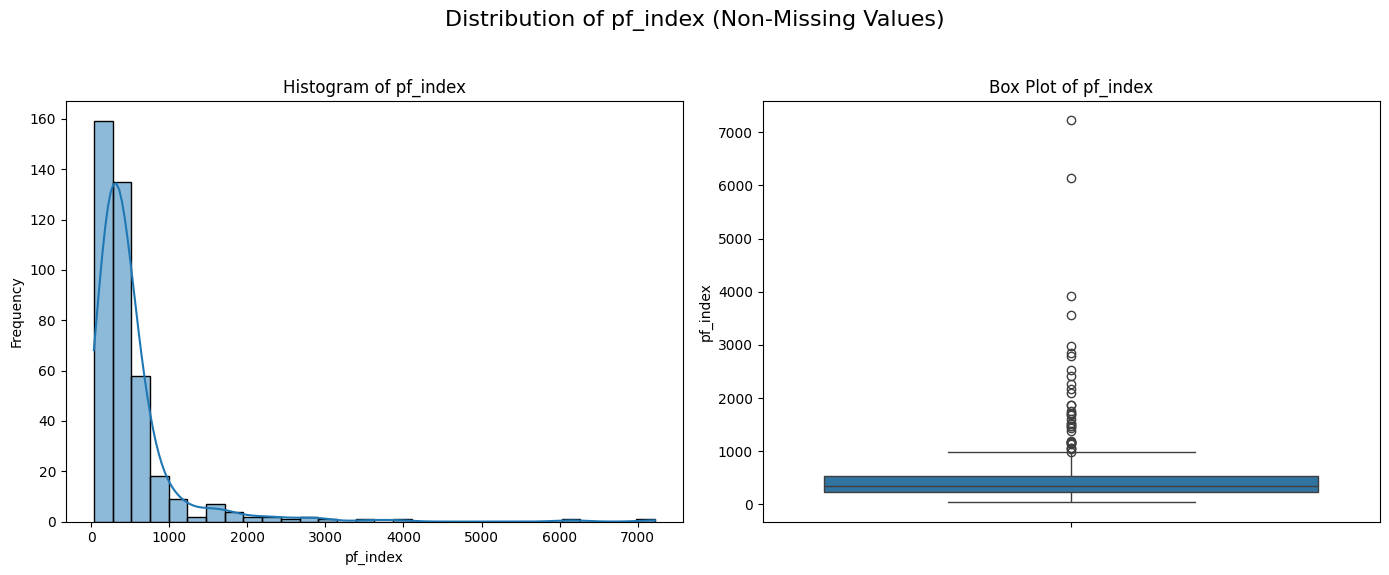


Potential outliers for pf_index (based on 1.5*IQR rule):
  Lower Bound: -235.7023
  Upper Bound: 987.2614
  Detected Outliers (35 values):
7       2178.000000
243     3565.300000
306     1063.965517
308     1509.750000
323     2533.698630
354     1430.000000
356     1185.333333
365     1717.245763
384     3912.281879
386     1869.957265
452     1134.000000
481     1157.207792
487     1699.380952
488     1606.880000
575     1687.585903
580     2791.475410
610     2838.000000
669     1058.628099
673     2255.590909
675     1385.700000
686     6133.700000
711     1171.200000
753     2098.359447
759     2413.446602
765     2980.215470
856     1480.400000
877     1869.400000
933     1753.100000
950     1164.000000
990      991.100000
1207    1523.900000
1209    1177.000000
1321    7221.800000
1323    1473.100000
1324    1032.000000
  Total non-missing values: 404

--- Feature Distribution Analysis (for pf_index) ---

Basic Statistics for Numeric Features used for pf_index:
                

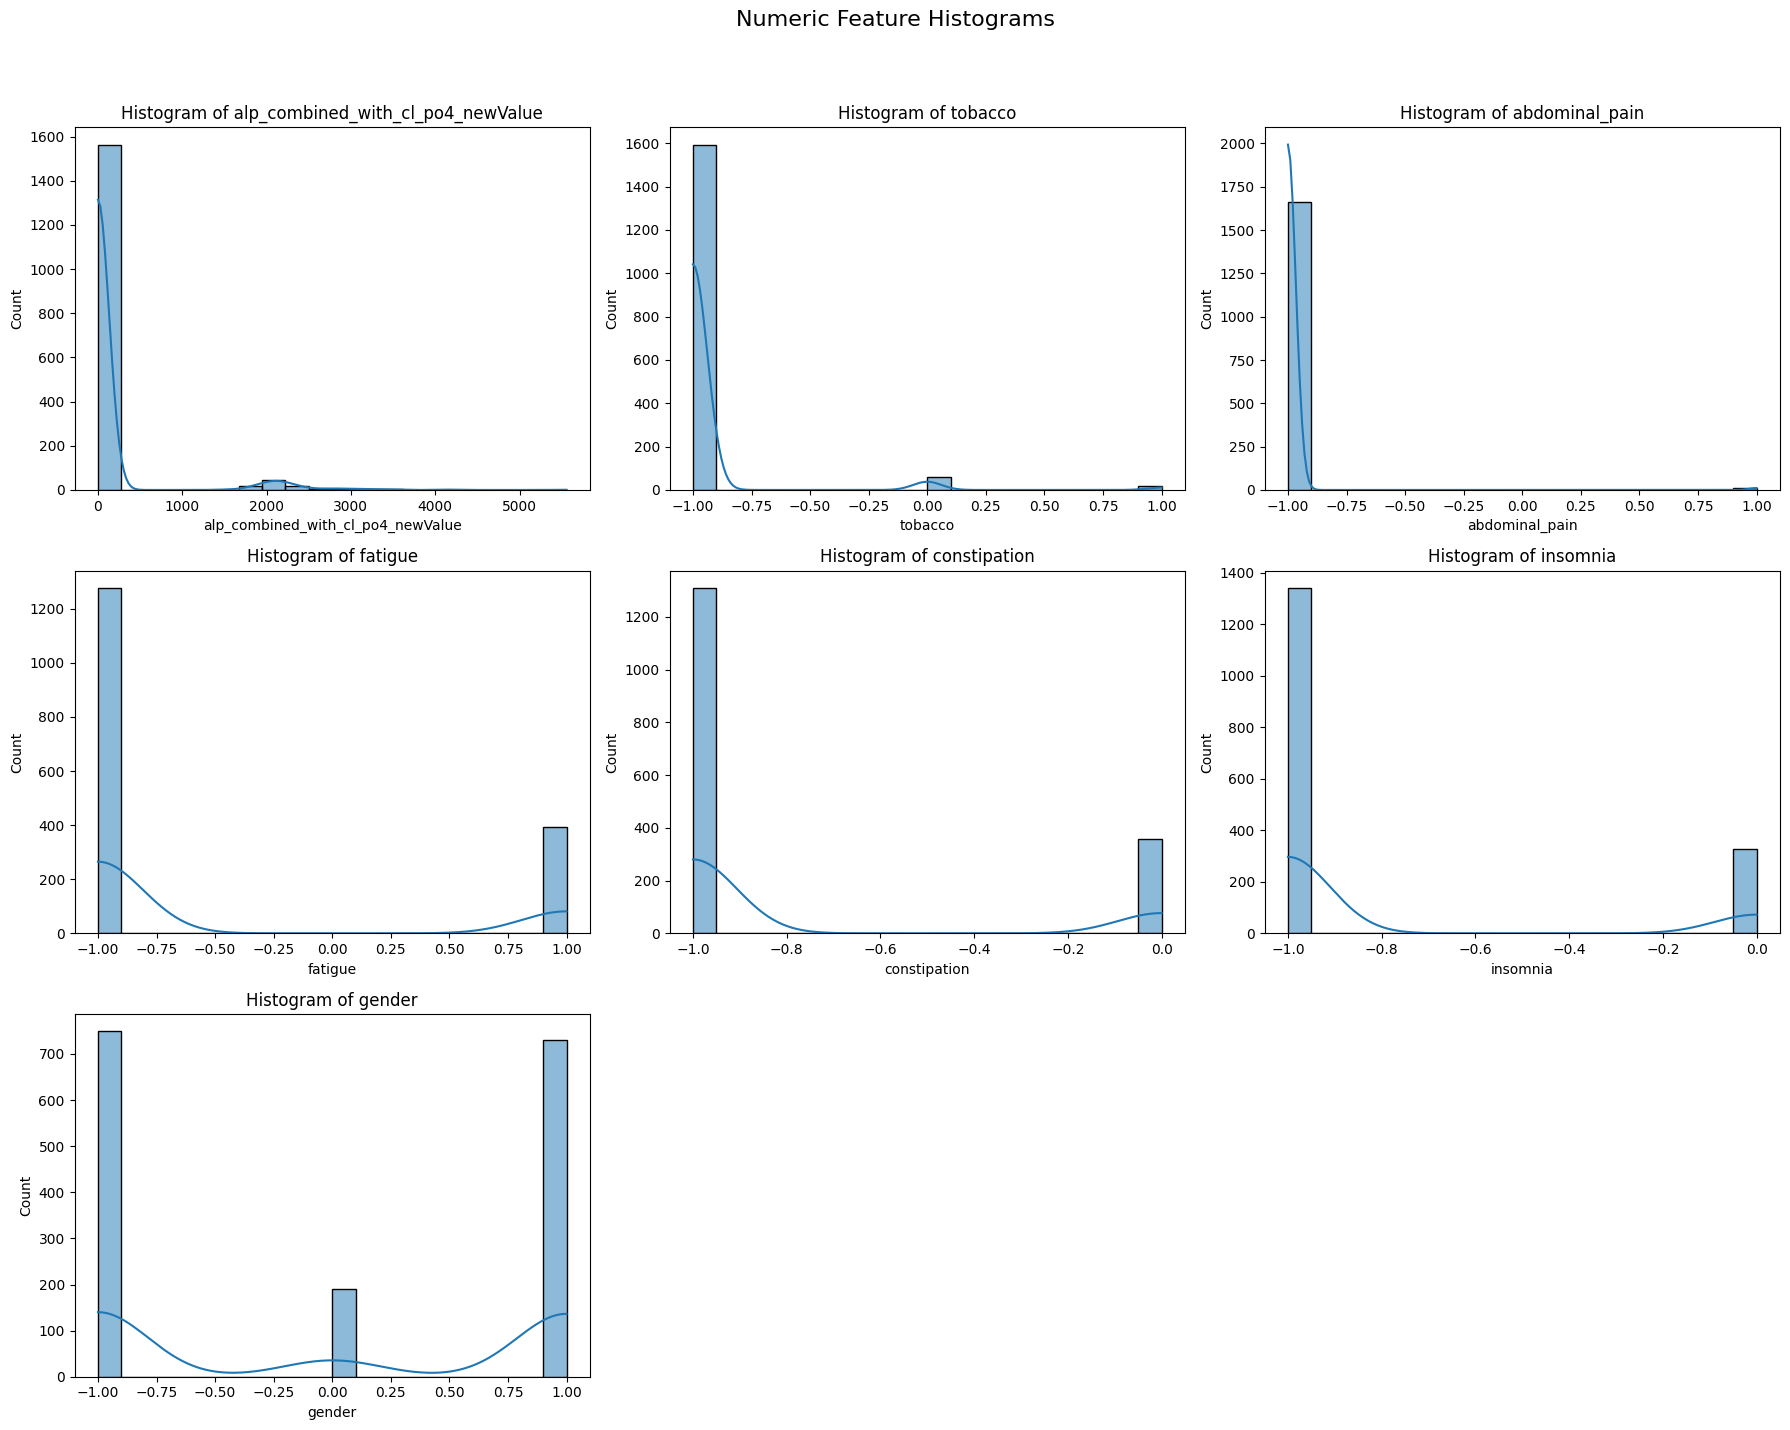

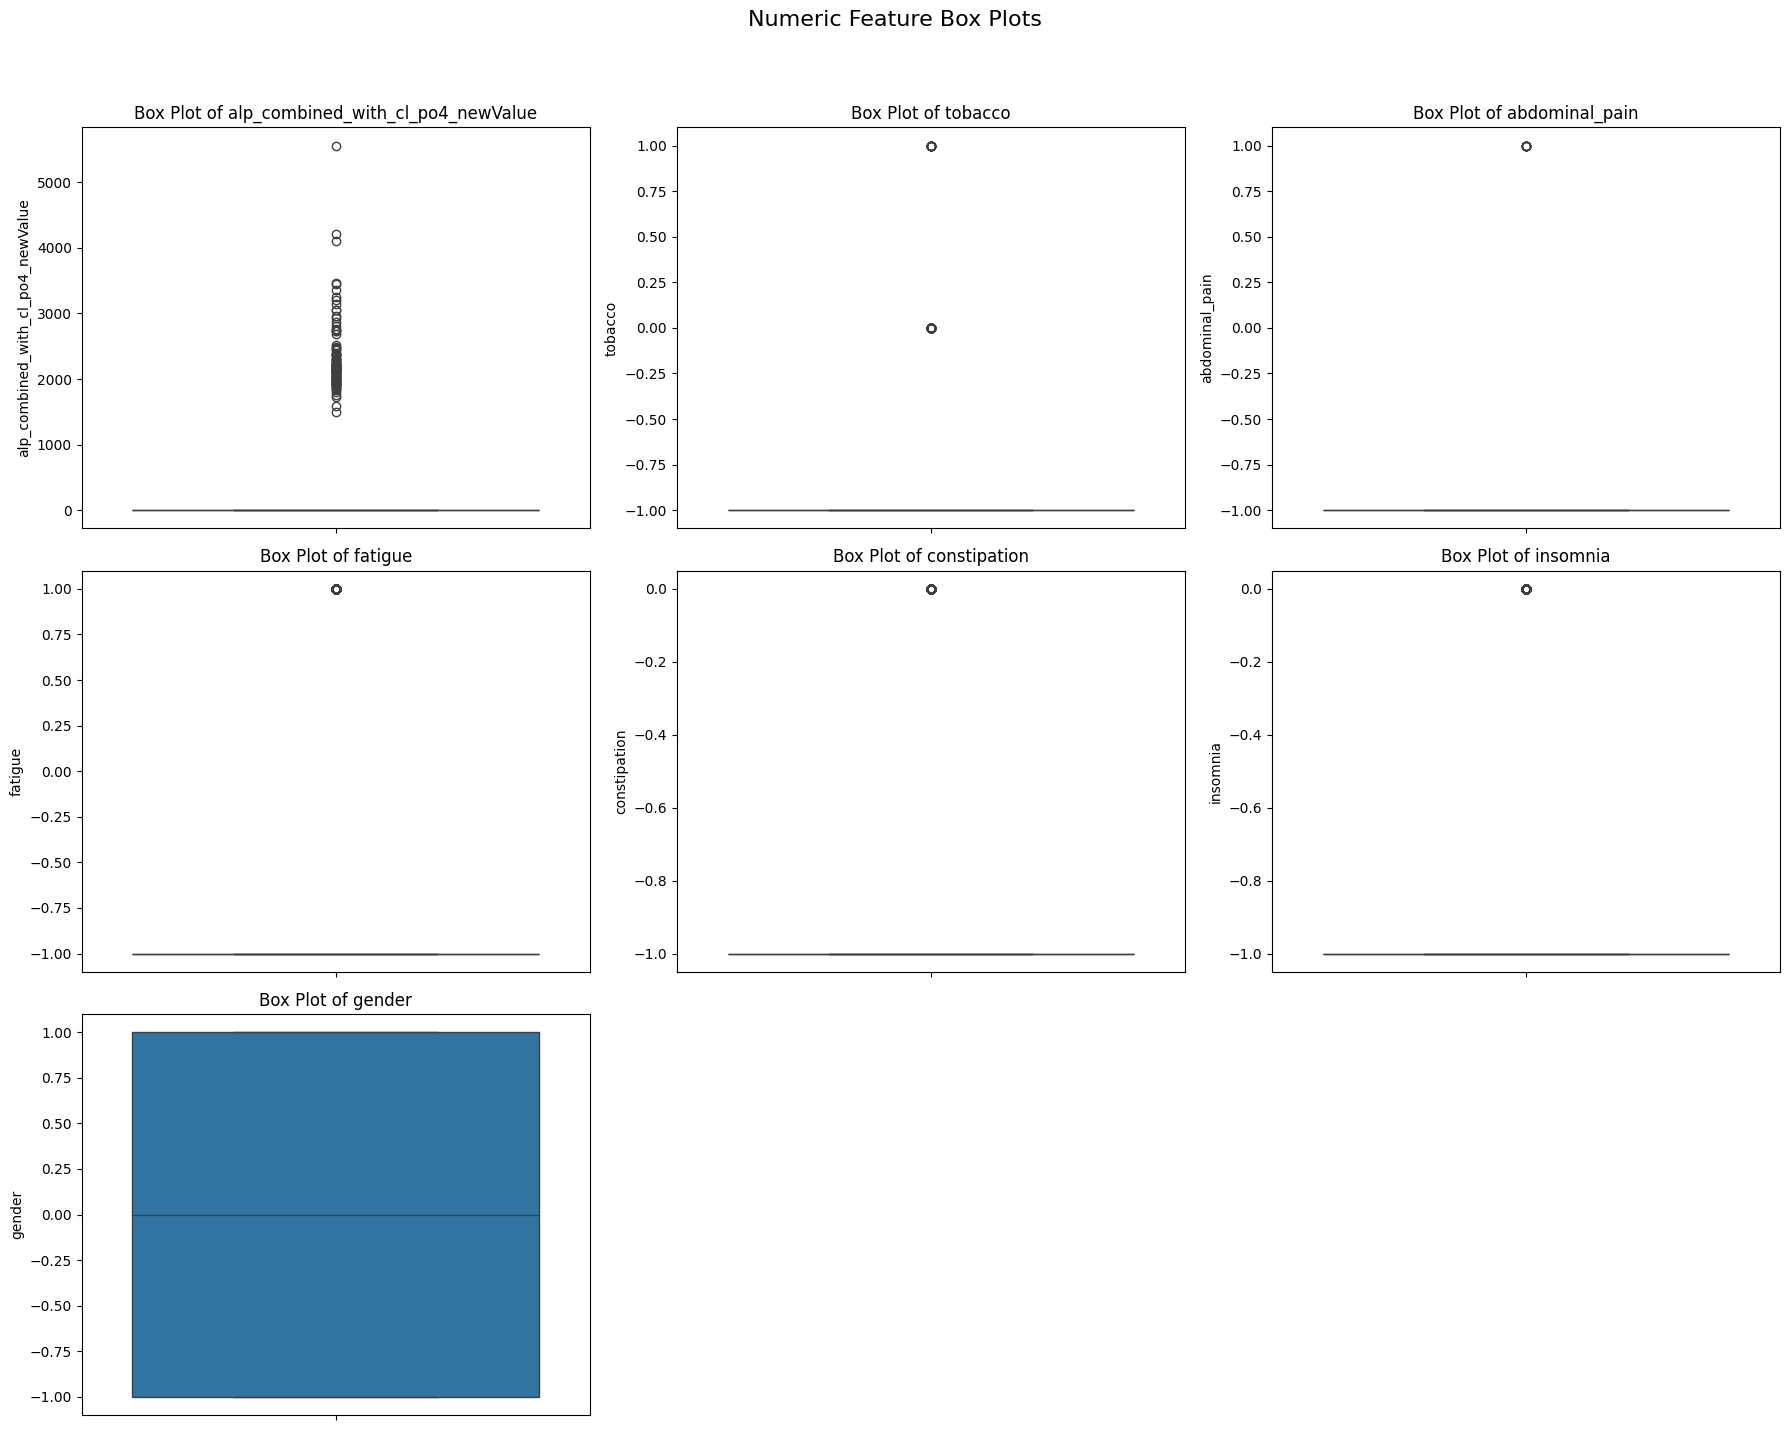


No categorical features identified among the available features for analysis.

--- Correlation Analysis (pf_index vs Numeric Features) ---

Correlation of numeric features with pf_index:
alp_combined_with_cl_po4_newValue    0.162203
tobacco                              0.132404
abdominal_pain                       0.127386
fatigue                              0.069366
insomnia                             0.050383
constipation                         0.046779
gender                              -0.088006
Name: pf_index, dtype: float64


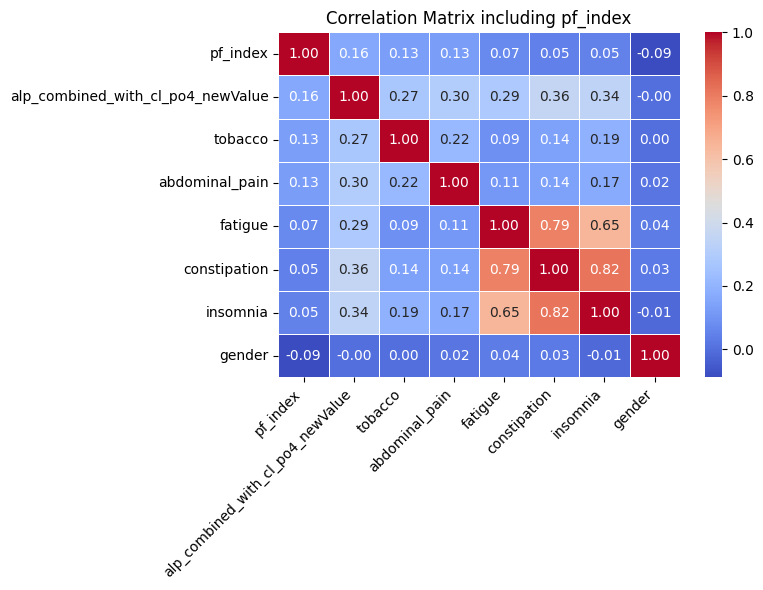


--- Scatter Plots (pf_index vs Numeric Features) ---


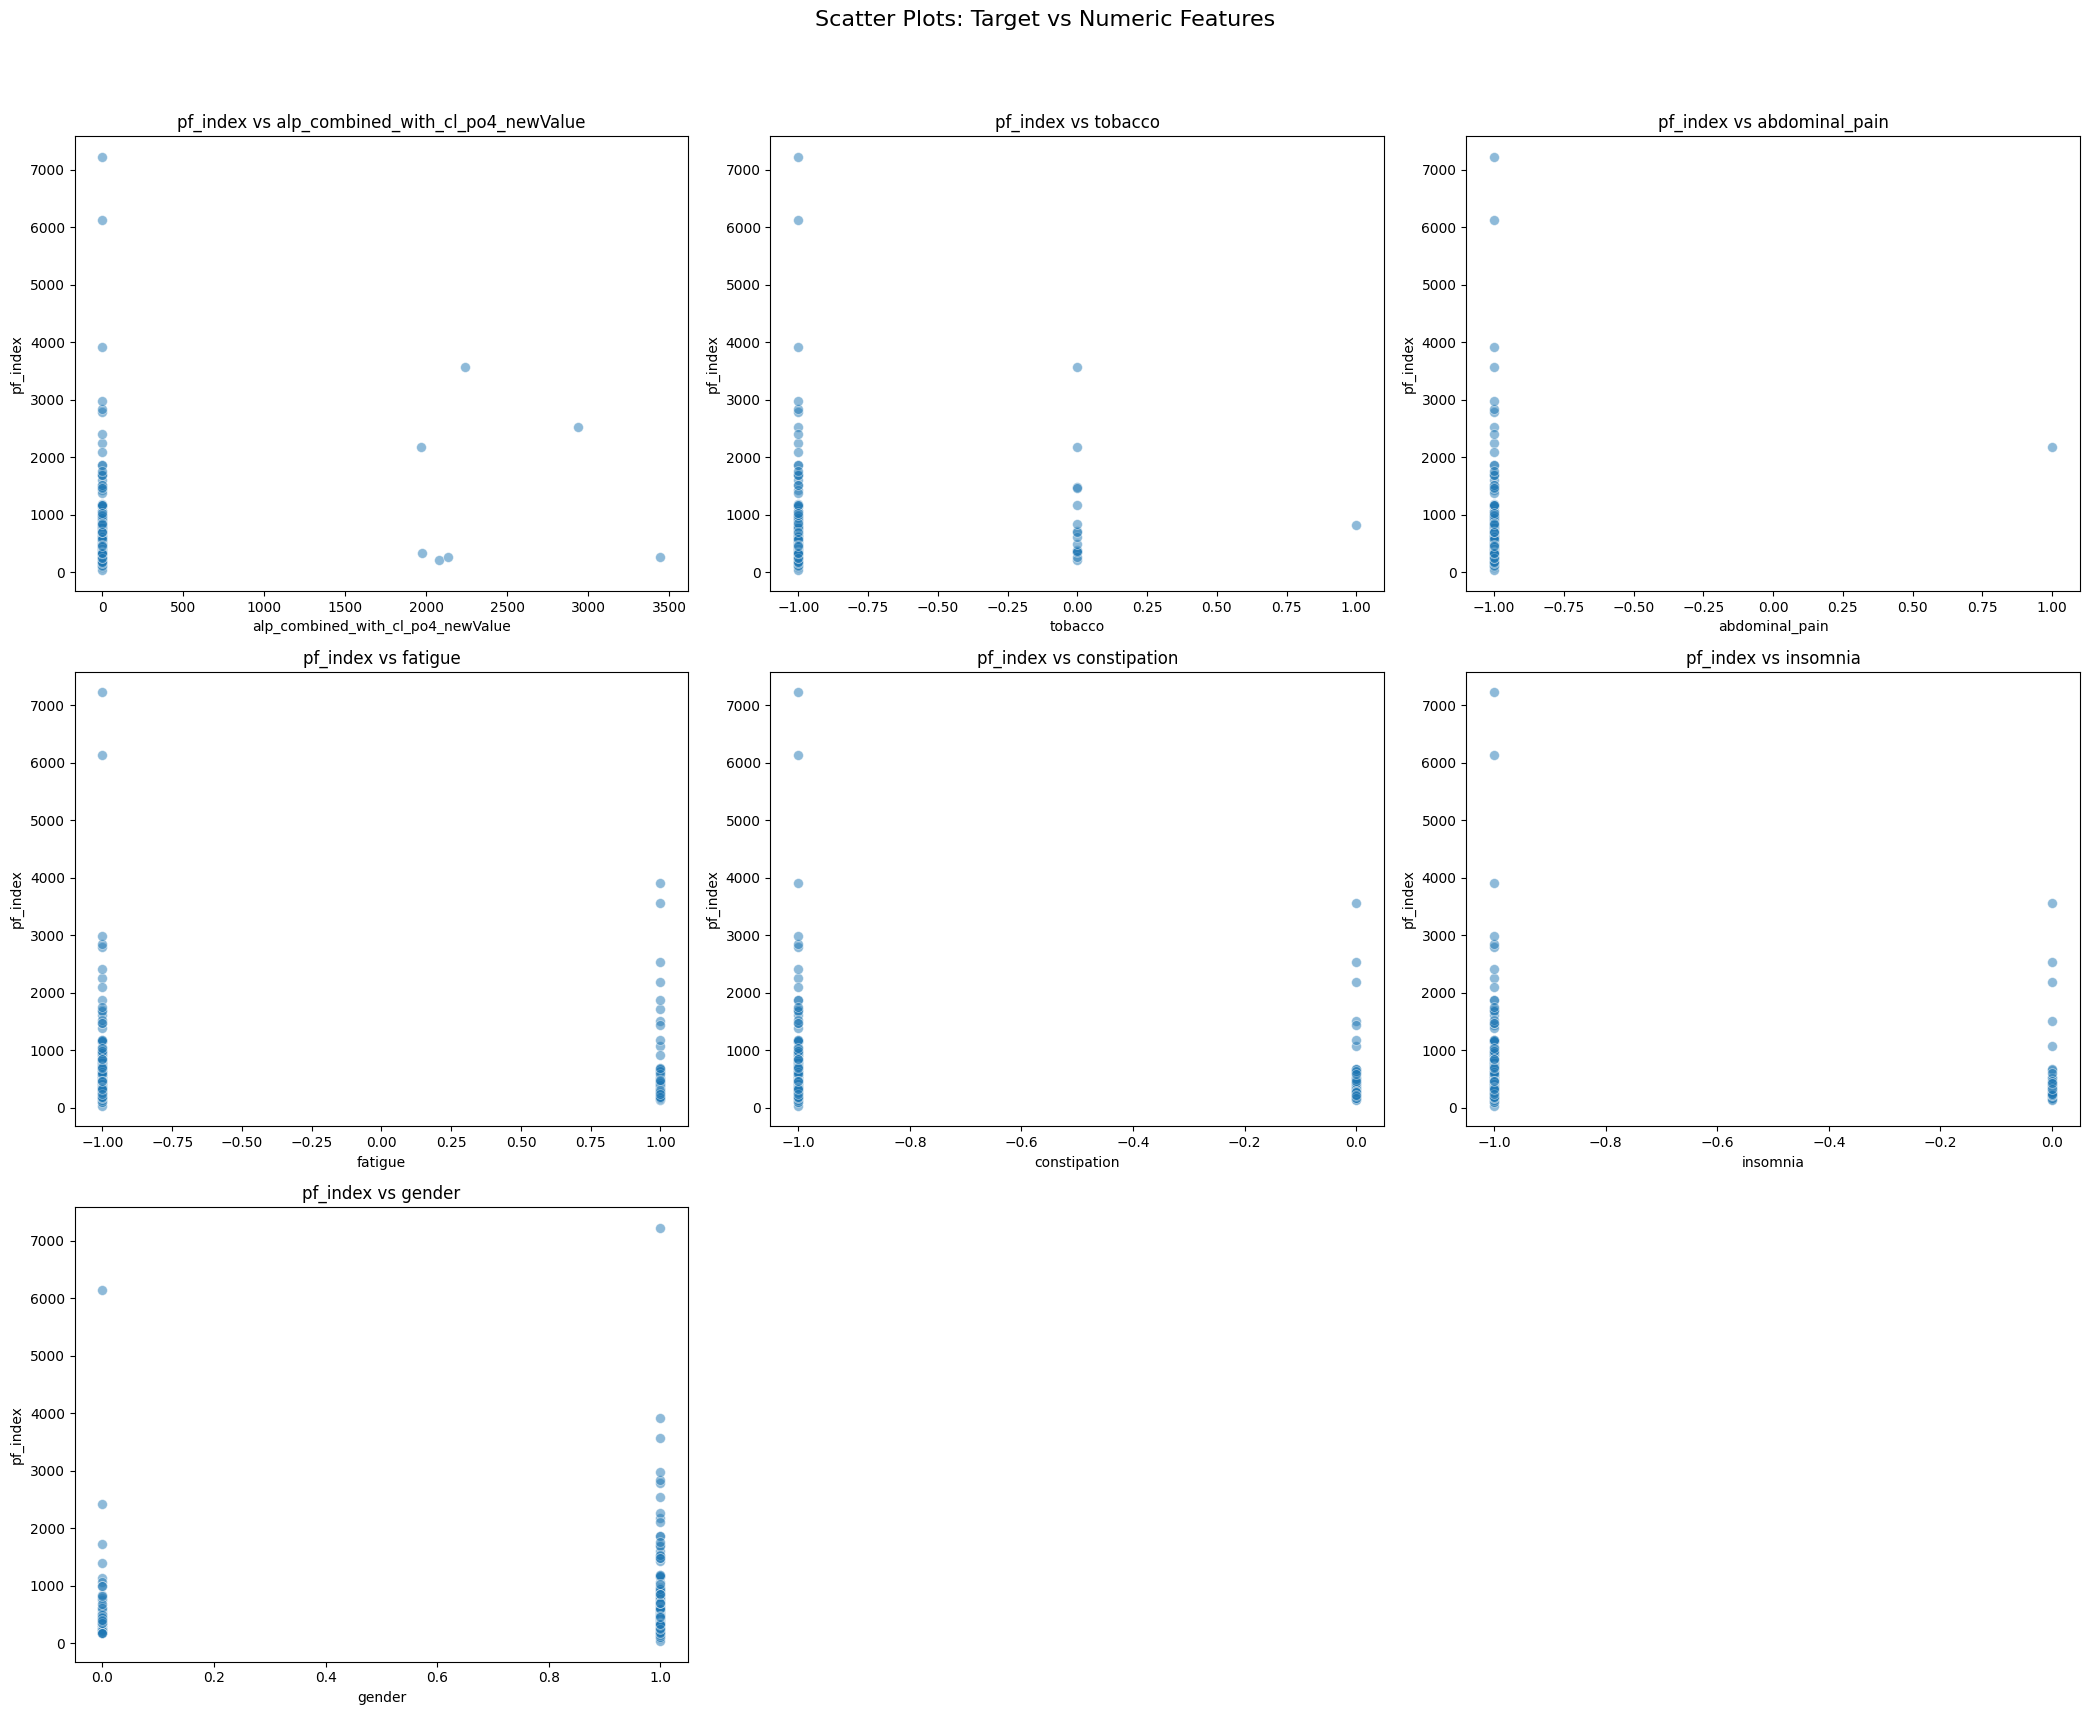


--- Analysis of Potential Evaluation Samples for pf_index ---
Examining the first 10 rows (out of 404) with non-missing 'pf_index'.
Indices: [7, 30, 243, 244, 250, 251, 252, 253, 255, 256]

Data for these potential evaluation samples:
     pf_index  alp_combined_with_cl_po4_newValue  tobacco  abdominal_pain  fatigue  constipation  insomnia  gender
7     2178.00                        1967.142857        0               1        1             0         0       1
30     394.00                           0.000000        0              -1        1             0         0       1
243   3565.30                        2237.368421        0              -1        1             0         0       1
244    157.92                           0.000000       -1              -1        1             0         0       1
250    346.00                           0.000000        0              -1        1             0         0       1
251    213.00                        2078.947368        0              -1 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler # Keep if you want to inspect scaled features later

# --- 1. Load Data (Same as original) ---
# Make sure this path is correct
input_path = r"C:\Users\musab\Desktop\htOld\2025\code\hyperThyroid2025April11ExcelCSV.csv"
try:
    # Try utf-8 first, fallback to latin-1 if needed
    try:
        df = pd.read_csv(input_path, encoding='utf-8')
    except UnicodeDecodeError:
        print("UTF-8 failed, trying latin-1 encoding...")
        df = pd.read_csv(input_path, encoding='latin-1')

    print("Original Data Shape:", df.shape)
    # print("Original Columns:", list(df.columns)) # Optionally print all columns
except FileNotFoundError:
    print(f"Error: Input file not found at {input_path}")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

# --- 2. Define Target and Features for Investigation ---
target_col = 'pf_index'

# Copy the relevant part of your imputation map
imputation_map = {
     'pf_index': [
        # This first feature was likely missing based on warnings in the original script
        'alp_combined_with_cl_po4_newValue',
        'tobacco', 'abdominal_pain', 'fatigue',
        'constipation', 'insomnia', 'gender'
     ],
     # Add other entries if needed for context, but pf_index is key here
}

if target_col not in imputation_map:
    print(f"Error: '{target_col}' not found as a key in the provided imputation_map dictionary.")
    exit()
# Get the list of intended features from the map
feature_cols_intended = imputation_map[target_col]

# IMPORTANT: Check which of these features actually exist in the DataFrame columns
feature_cols = [f for f in feature_cols_intended if f in df.columns]
missing_features = [f for f in feature_cols_intended if f not in df.columns]

print(f"\n--- Investigating High Error for Target: {target_col} ---")
if missing_features:
    print(f"\n*** CRITICAL WARNING ***")
    print(f"The following features defined for '{target_col}' are MISSING in the loaded CSV:")
    print(f"  >> {missing_features} <<")
    print(f"This is a likely major contributor to poor imputation performance.")
    print(f"Analysis will proceed using only the available features:")
else:
    print("All intended features found in the DataFrame.")

print(f"Using available features: {feature_cols}")

if not feature_cols:
    print(f"\nError: None of the specified features for '{target_col}' exist in the DataFrame. Cannot proceed with analysis.")
    exit()

# Ensure target column exists and attempt numeric conversion
if target_col in df.columns:
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    if df[target_col].isnull().all():
         print(f"\nWarning: Target column '{target_col}' is entirely NaN after numeric conversion. No data to analyze.")
         # Decide whether to exit or continue analysis on features only
         # exit()
    elif df[target_col].notna().sum() == 0:
         print(f"\nWarning: Target column '{target_col}' has no non-missing values after numeric conversion.")
         # Decide whether to exit or continue analysis on features only
         # exit()

else:
    print(f"\nError: Target column '{target_col}' not found in the DataFrame.")
    exit()

# --- 3. Analyze Target Variable Distribution ('pf_index') ---
print(f"\n--- {target_col} Distribution Analysis ---")
pf_index_data = df[target_col].dropna() # Use only non-missing values

if not pf_index_data.empty:
    print(f"\nBasic Statistics for {target_col}:")
    print(pf_index_data.describe())

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(pf_index_data, kde=True, bins=30) # Use more bins if needed
    plt.title(f'Histogram of {target_col}')
    plt.xlabel(target_col)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=pf_index_data)
    plt.title(f'Box Plot of {target_col}')
    plt.ylabel(target_col)

    plt.suptitle(f'Distribution of {target_col} (Non-Missing Values)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # Identify potential outliers using the IQR method
    Q1 = pf_index_data.quantile(0.25)
    Q3 = pf_index_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = pf_index_data[(pf_index_data < lower_bound) | (pf_index_data > upper_bound)]

    print(f"\nPotential outliers for {target_col} (based on 1.5*IQR rule):")
    print(f"  Lower Bound: {lower_bound:.4f}")
    print(f"  Upper Bound: {upper_bound:.4f}")
    if not outliers.empty:
        print(f"  Detected Outliers ({len(outliers)} values):")
        print(outliers.to_string()) # Display the outlier values
    else:
        print("  No outliers detected using the 1.5*IQR rule.")
    print(f"  Total non-missing values: {len(pf_index_data)}")

    # Check for zeros if relative error is the main concern
    if (pf_index_data == 0).any():
        print("\nWarning: Zero values detected in pf_index. This can inflate Mean Relative Error.")

else:
    print(f"No non-missing data available for '{target_col}' to analyze distribution.")


# --- 4. Analyze Feature Distributions ---
print(f"\n--- Feature Distribution Analysis (for {target_col}) ---")
# Separate numeric and categorical features from the *available* list
df_features = df[feature_cols].copy() # Work on a copy

# Attempt to convert binary-like (0, 1, -1) or other potential numerics if they aren't already
for f in feature_cols:
    # Check if the column is not already numeric
    if not pd.api.types.is_numeric_dtype(df_features[f]):
        # Try converting to numeric, coercing errors. Check if it's mostly numeric after.
        original_non_na = df_features[f].notna().sum()
        converted_col = pd.to_numeric(df_features[f], errors='coerce')
        # If conversion results in mostly numbers, keep it numeric
        if converted_col.notna().sum() / original_non_na > 0.8: # Heuristic: if >80% are numeric after coercion
             df_features[f] = converted_col
             print(f"  Info: Coerced feature '{f}' to numeric for analysis.")


numeric_features = df_features.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_features.select_dtypes(exclude=np.number).columns.tolist()

if numeric_features:
    print(f"\nBasic Statistics for Numeric Features used for {target_col}:")
    print(df_features[numeric_features].describe().T)

    print(f"\nVisualizing Numeric Feature Distributions:")
    n_numeric = len(numeric_features)
    if n_numeric > 0:
        n_cols_plot = min(3, n_numeric) # Max 3 plots per row
        n_rows_plot = (n_numeric + n_cols_plot - 1) // n_cols_plot

        plt.figure(figsize=(6 * n_cols_plot, 5 * n_rows_plot))
        for i, feat in enumerate(numeric_features):
            plt.subplot(n_rows_plot, n_cols_plot, i + 1)
            sns.histplot(df_features[feat].dropna(), kde=True, bins=20)
            plt.title(f'Histogram of {feat}')
        plt.suptitle('Numeric Feature Histograms', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        plt.figure(figsize=(6 * n_cols_plot, 5 * n_rows_plot))
        for i, feat in enumerate(numeric_features):
             plt.subplot(n_rows_plot, n_cols_plot, i + 1)
             sns.boxplot(y=df_features[feat].dropna())
             plt.title(f'Box Plot of {feat}')
        plt.suptitle('Numeric Feature Box Plots', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
else:
    print("\nNo numeric features identified among the available features for analysis.")


if categorical_features:
    print(f"\nValue Counts for Categorical Features used for {target_col}:")
    n_cat = len(categorical_features)
    if n_cat > 0:
        n_cols_plot = min(3, n_cat)
        n_rows_plot = (n_cat + n_cols_plot - 1) // n_cols_plot
        plt.figure(figsize=(6 * n_cols_plot, 5 * n_rows_plot))
        for i, feat in enumerate(categorical_features):
            print(f"\n-- {feat} --")
            # Include NaNs in counts, normalize to see percentages
            print(df_features[feat].value_counts(dropna=False, normalize=True).map("{:.2%}".format))

            plt.subplot(n_rows_plot, n_cols_plot, i + 1)
            # Order bars by frequency
            order = df_features[feat].value_counts().index
            sns.countplot(data=df_features, y=feat, order=order, palette='viridis')
            plt.title(f'Count Plot for {feat}')
            plt.xlabel('Count')
            plt.ylabel('') # Feature name is clear from title

        plt.suptitle('Categorical Feature Counts', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
else:
     print("\nNo categorical features identified among the available features for analysis.")


# --- 5. Correlation Analysis ---
print(f"\n--- Correlation Analysis ({target_col} vs Numeric Features) ---")
# Combine target and numeric features for correlation calculation
cols_for_corr = [target_col] + numeric_features

# Need at least one numeric feature and non-missing target data
if numeric_features and not pf_index_data.empty:
    # Use only rows where the target is not null for correlation
    correlation_matrix = df[cols_for_corr].dropna(subset=[target_col]).corr()

    if target_col in correlation_matrix:
        target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)
        print(f"\nCorrelation of numeric features with {target_col}:")
        if not target_correlations.empty:
            print(target_correlations)
        else:
            print("No numeric features to correlate with.")

        # Visualize the correlation matrix
        plt.figure(figsize=(max(8, len(cols_for_corr)*0.8), max(6, len(cols_for_corr)*0.6)))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Correlation Matrix including {target_col}')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
         print("Could not compute correlations (target column might have issues).")

else:
    print("Cannot calculate correlations: No numeric features available or no non-missing target data.")


# --- 6. Scatter Plots (Target vs Numeric Features) ---
print(f"\n--- Scatter Plots ({target_col} vs Numeric Features) ---")
if numeric_features and not pf_index_data.empty:
    n_numeric = len(numeric_features)
    n_cols_plot = min(3, n_numeric)
    n_rows_plot = (n_numeric + n_cols_plot - 1) // n_cols_plot

    plt.figure(figsize=(7 * n_cols_plot, 6 * n_rows_plot))
    for i, feat in enumerate(numeric_features):
        plt.subplot(n_rows_plot, n_cols_plot, i + 1)
        sns.scatterplot(data=df, x=feat, y=target_col, alpha=0.5, s=50) # Adjust alpha/size
        # Optional: Add a regression line
        # sns.regplot(data=df, x=feat, y=target_col, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.title(f'{target_col} vs {feat}')
    plt.suptitle('Scatter Plots: Target vs Numeric Features', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Cannot create scatter plots: No numeric features or no non-missing target data.")


# --- 7. Examine Evaluation Sample Characteristics ---
print(f"\n--- Analysis of Potential Evaluation Samples for {target_col} ---")
# Find the indices of rows where the original target is not missing
non_missing_indices = df[df[target_col].notna()].index
n_total_non_missing = len(non_missing_indices)
n_eval = min(10, n_total_non_missing) # Max 10 samples used in original eval

if n_eval > 0:
    # Get the indices that *would have been* selected for evaluation
    valid_idx = non_missing_indices[:n_eval]
    print(f"Examining the first {n_eval} rows (out of {n_total_non_missing}) with non-missing '{target_col}'.")
    print(f"Indices: {list(valid_idx)}")

    # Select these rows and the relevant columns (target + available features)
    eval_sample_df = df.loc[valid_idx, [target_col] + feature_cols].copy()

    print("\nData for these potential evaluation samples:")
    print(eval_sample_df.to_string())

    print(f"\nComparison: Statistics of these {n_eval} samples vs. Overall Data")
    # Create a comparison DataFrame
    stats_compare = pd.DataFrame({
        'Eval Sample Mean': eval_sample_df.mean(numeric_only=True),
        'Overall Mean': df[[target_col] + numeric_features].mean(numeric_only=True),
        'Eval Sample Std': eval_sample_df.std(numeric_only=True),
        'Overall Std': df[[target_col] + numeric_features].std(numeric_only=True),
        'Eval Sample Min': eval_sample_df.min(numeric_only=True),
        'Overall Min': df[[target_col] + numeric_features].min(numeric_only=True),
        'Eval Sample Max': eval_sample_df.max(numeric_only=True),
        'Overall Max': df[[target_col] + numeric_features].max(numeric_only=True),
    })
    print(stats_compare.to_string(float_format="{:.2f}".format))


    # Highlight potential issues in the evaluation sample
    # Are target values in eval sample extreme compared to overall?
    eval_target_stats = eval_sample_df[target_col].describe()
    overall_target_stats = pf_index_data.describe() # Use previously calculated stats

    if eval_target_stats['max'] > upper_bound or eval_target_stats['min'] < lower_bound:
        print(f"\nWarning: Potential evaluation sample(s) for '{target_col}' contain values outside the 1.5*IQR range of the overall data.")
        print(f"  Eval Range: [{eval_target_stats['min']:.2f}, {eval_target_stats['max']:.2f}] vs Overall IQR Range: [{lower_bound:.2f}, {upper_bound:.2f}]")

    # You could add similar checks for features if needed

else:
    print(f"No non-missing values found for '{target_col}', so no evaluation samples to examine.")

print("\n--- Investigation Finished ---")